In [3]:
import pandas as pd

# 製作寶典
df1 = pd.read_excel('../data/台塑企業_ 產品寶典20210303.xlsx',engine='openpyxl').iloc[:,:-1]
df2 = pd.read_excel('../data/寶典.v3.台塑網.20210901.xlsx',engine='openpyxl')
df2.columns = df1.columns
df = df1.append(df2)
df['品名'] = df['品名'].apply(lambda x:x.strip())
val_df = pd.read_csv('../data/preprocess_for_SQUAD_產品.csv',index_col=0)[['string_X_train','Y_label','EXPNO','from']]
寶典 = set(df['品名'].values.tolist() + val_df.loc[:,'Y_label'].values.tolist())

# 讀取no label data
df = pd.read_csv('../submit/no_label_data.csv',index_col=0)

# select 成功 label data
df_label = df[df.predict.isin(寶典)]
df_label = df_label.rename(columns={'predict':'Y_label'})

# 起始結束位置標註 Y1 Y2
def str2index(context,string):
    ys = context.find(string)
    ye = ys + len(string)
    return ys,ye

ys_lst,ye_lst = [],[]
for i in range(len(df_label)):
    ys,ye = str2index(df_label['string_X_train'].values[i],df_label['Y_label'].values[i])
    ys_lst.append(ys),ye_lst.append(ye)
    
df_label['string_Y_1'] = ys_lst
df_label['string_Y_2'] = ye_lst

# df_label 是用bert inference出的的 no_label_data 用來做數據擴充
print(df_label.shape)
df_label.head()

(614, 6)


,string_X_train,Y_label,EXPNO,from,string_Y_1,string_Y_2
1,17 MT PVC COPOLYMER RESIN C15 AT USD 1470 P...,PVC COPOLYMER,NaN,20210103.xlsx,7,20
3,MASS PVC RESIN B57QUANTITY 175 MT AT 1300 USDM...,PVC RESIN,11,20210103.xlsx,5,14
20,FOR PRESENTATION OF FOLLOWING CONFORM DOCUMENT...,SAP,NaN,20210103.xlsx,93,96
67,54 MT OF PVC RESIN SUSPENSION S65DAT USD 1270 ...,PVC RESIN,11,20210103.xlsx,9,18
92,5250 MTS PVC RESIN B57 AT USD 1320 PER MT AS P...,PVC RESIN,NaN,20210103.xlsx,9,18


Global seed set to 42


(9574, 6) (2240, 6)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode


epoch:0 train_loss:0.32646479002847856 val_loss:0.5524132435467081
save best_model now_val_best_loss is:0.5524132435467081



epoch:1 train_loss:0.25243620670608535 val_loss:1.3724029159246807



epoch:2 train_loss:0.1804294741193309 val_loss:0.6454713953839194



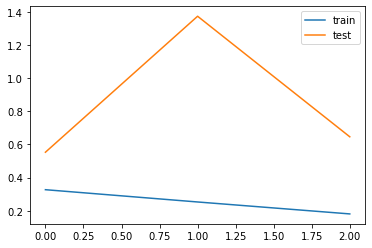

best_model is saved!


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

In [4]:
import requests
import gc
import pandas as pd
import requests
from sklearn.model_selection import train_test_split
gc.collect()

df = pd.read_csv('../data/preprocess_for_SQUAD_產品.csv',index_col=0)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
url = 'https://gist.githubusercontent.com/skywalker0803r/1e1d0d25999094bf8ec23dc143e02478/raw/2b751c959a1b48a14e627eaf956f9ae3df821f46/bert_train_pipeline.py'
exec(requests.get(url).text)
qustion = 'What is the product name?'
model_path = '../models/Product_Data_SQuAD_model_product.pt'
train_df = train_df.append(df_label) # 數據擴充
print(train_df.shape,val_df.shape)
res,table = bert_train_pipeline(train_df,val_df,qustion,model_path)

In [5]:
res

,jaccard,acc(1.0),acc(0.75),acc(0.5),acc(0.25)
0,0.836139,0.785268,0.785714,0.849107,0.887054


In [6]:
table

,Y_label,predict,是否全對
4499,METHYL METHACRYLATE,METHYL METHACRYLATE,Yes
3653,GRADE,GRADE,Yes
4883,AG12A0,ACRYLONITRILE,No
7498,AG12A0,ACRYLONITRILE,No
17941,GRADE,TAIRILIN,No
...,...,...,...
3342,GRADE,GRADE,Yes
16593,METHYL METHACRYLATE,METHYL METHACRYLATE,Yes
20414,ACID,ACID,Yes
593,TAISOX 7470M,TAISOX 7240M,No
